In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame
# from MyLearner import MyLearner

# from MyScorer import MyScorer
# from MyPlotter import MyPlotter

import pandas as pd
import numpy as np
import string
import itertools

import math
import scipy.stats as sts
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
import sklearn.feature_selection as feature_selection
import sklearn.preprocessing as prepc
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.multiclass import OneVsOneClassifier as ovo
from sklearn.multiclass import OutputCodeClassifier as occ
import sklearn
import sklearn.metrics as metrics
from rfpimp import dropcol_importances
from rfpimp import importances
import imblearn.over_sampling as imbOVS
import imblearn.under_sampling as imbUDS
import imblearn.combine as imbCMB

from dabl.plot import class_hists

c:\00_data\python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

### Training Set

In [3]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Set

In [4]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Checking missing values in training set

In [5]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

### Checking missing values in test set

In [6]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


#### Calculate survival rate

In [7]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

In [8]:
data = data_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()

#encode categorical variables
data['Sex'] = data['Sex'].apply(lambda i: 1 if i=='male' else 0)
data['Embarked'] = data['Embarked'].apply(lambda i: 0 if i=='C' else (1 if i=='Q' else 2))
data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
# data = pd.concat([data.drop(columns=['Sex', 'Embarked']), df1, df2], axis=1)

#add family size
data['famsize'] = data['SibSp'] + data['Parch']

#numerical data
data_num = data[['Age', 'Fare',]]

#categorical data
data_cat = data[['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'famsize']]

In [9]:
data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,famsize
0,0,2,1,22.0,1,0,7.2500,2,1
1,1,0,0,38.0,1,0,71.2833,0,1
2,1,2,0,26.0,0,0,7.9250,2,0
3,1,0,0,35.0,1,0,53.1000,2,1
4,0,2,1,35.0,0,0,8.0500,2,0


### Plotting Variables

In [10]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

In [11]:
def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

In [12]:
def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

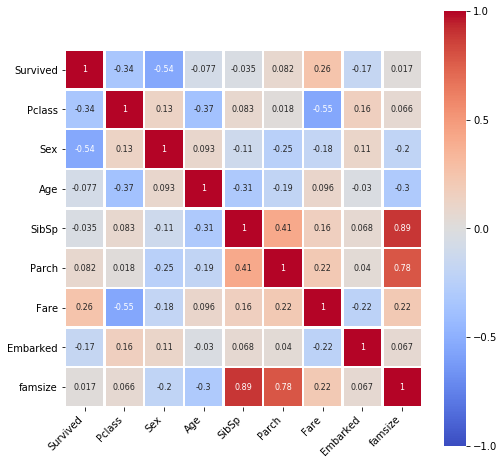

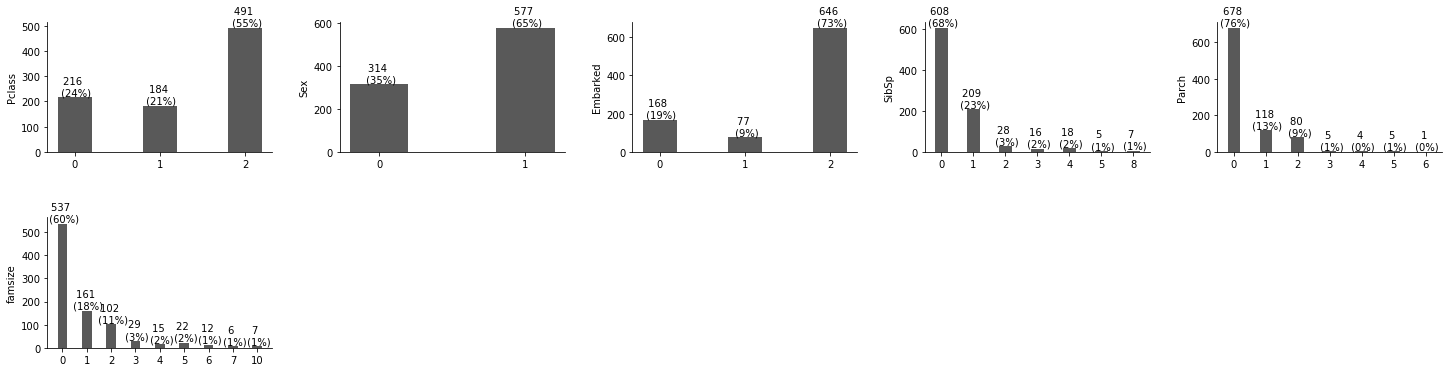

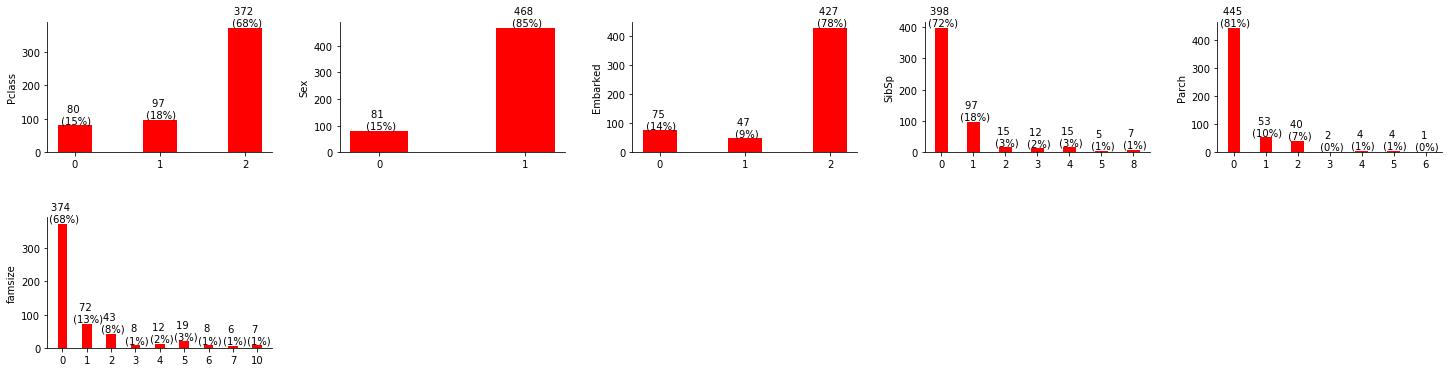

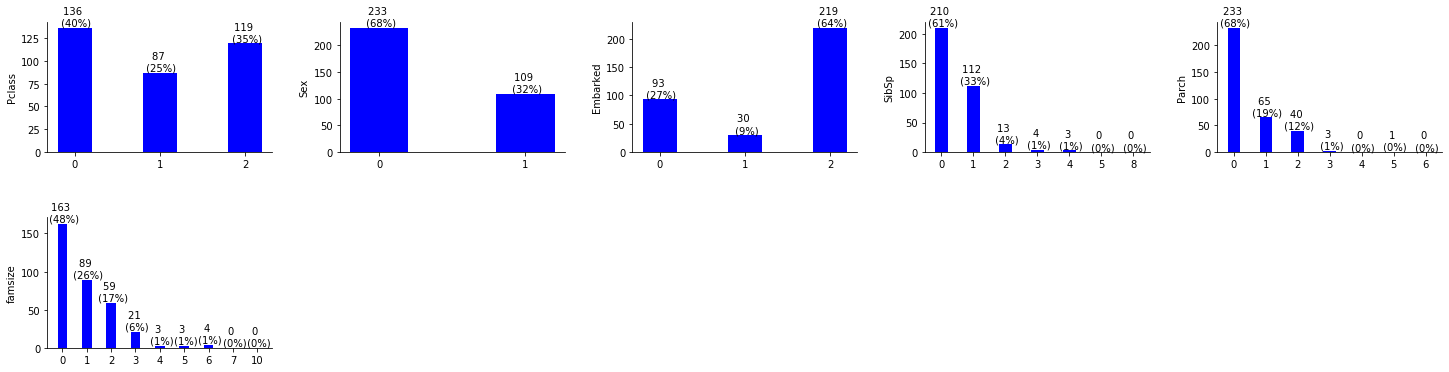

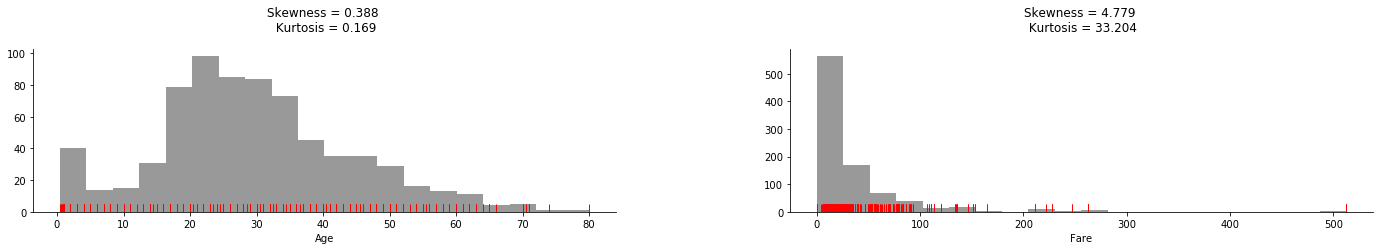

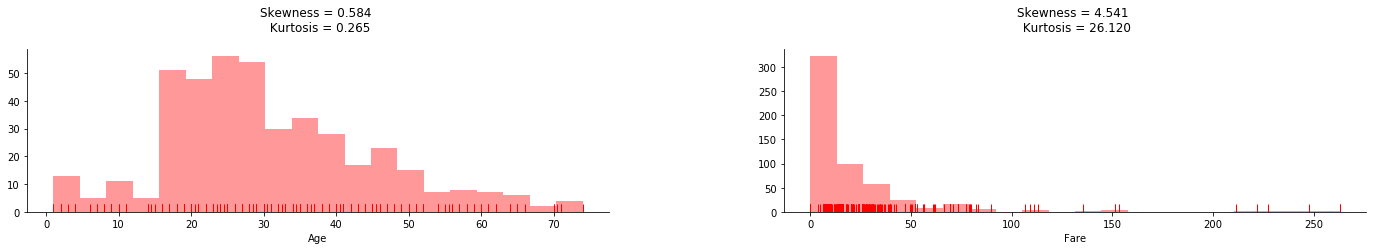

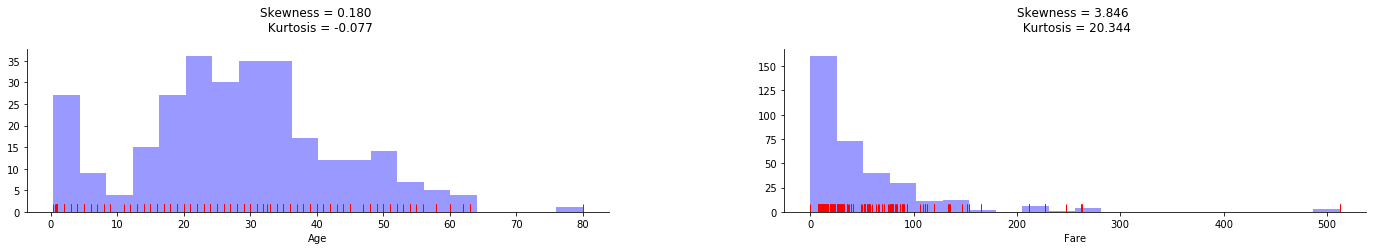

In [13]:
#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')


grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


#### Define age intervals using clastering

In [14]:
#Transform 'Age'
df_age = data_train['Age'].dropna()

age_trans = df_age.apply(lambda i: np.log(i+1)).to_frame()
age_trans.columns = ['Age_trans']
df_age = pd.concat([df_age.to_frame(), age_trans], axis=1)

In [15]:
#Define clustering model
age_clast_model = mix.BayesianGaussianMixture(n_components=2, covariance_type='spherical', tol=0.001, reg_covar=1e-06, max_iter=1000, n_init=1, 
                                 init_params='kmeans', weight_concentration_prior_type='dirichlet_distribution', 
                                 weight_concentration_prior=None, mean_precision_prior=None, mean_prior=None, 
                                 degrees_of_freedom_prior=None, covariance_prior=None, random_state=30)
                                 
#Predict class labels
age_cls = pd.DataFrame(age_clast_model.fit_predict(np.array(df_age['Age_trans']).reshape(-1,1)), columns=['Age_cls'])
age_cls = age_cls.astype(int)

In [16]:
df_age = pd.concat([df_age.reset_index(), age_cls], axis=1).drop(columns='index')

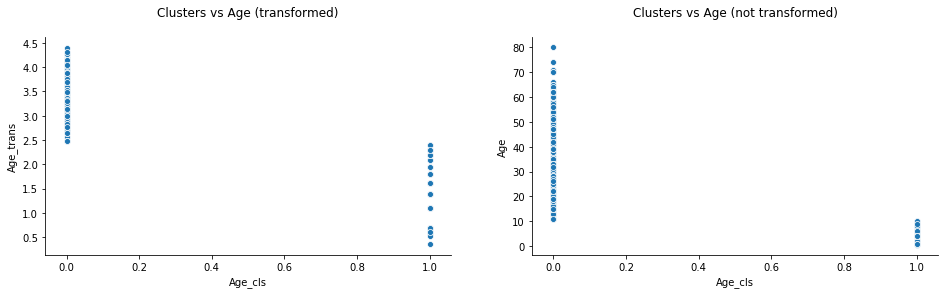

In [17]:
fig = plt.figure()
fig.set_size_inches(16,4)

fig.add_subplot(1,2,1)
ax = sns.scatterplot(x='Age_cls', y='Age_trans', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (transformed)')

fig.add_subplot(1,2,2)
ax = sns.scatterplot(x='Age_cls', y='Age', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (not transformed)')

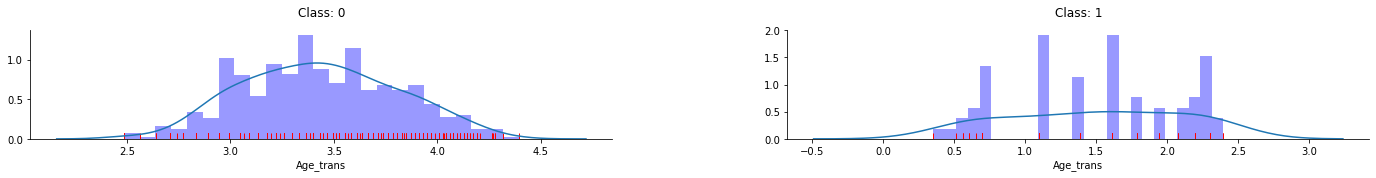

In [18]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age_trans']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

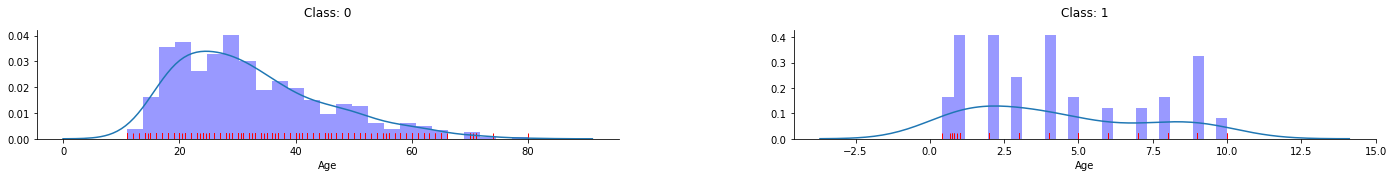

In [19]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

In [20]:
def age_transformer(data, model):
    age_trans = np.array(data['Age'].apply(lambda i: np.log(i+1))).reshape(-1,1)
    age_cls = pd.DataFrame(model.fit_predict(age_trans), columns=['Age_cls'])
    age_cls = age_cls.astype(int)
    data = pd.concat([data.drop(columns=['Age']).reset_index(), pd.DataFrame(age_trans, columns=['Age'])], axis=1).drop(columns='index')
    return pd.concat([data.reset_index(), age_cls], axis=1).drop(columns='index')

#### Replace 'Name' with encoded titles

In [21]:
#Concatinate train & test data
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [22]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(), data_encoded], axis=1).drop(columns=['index'])

In [23]:
data_tot = name_encoder(data_tot)
data_tot.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Thayer,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Peel,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,,Mr


In [24]:
#Find unique titles and their counts
ttl = data_tot['ttl'].unique()
ttl = pd.DataFrame([[i, len(data_tot.loc[data_tot['ttl']==i])] for i in ttl], columns=['ttl', 'ttl_n'])
ttl.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ttl,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer,Dona
ttl_n,757,197,260,61,1,8,8,1,2,2,1,1,2,4,1,1,1,1


In [25]:
#Explore samples with 'Dr' title
data_tot.loc[data_tot['ttl']=='Dr']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
245,246,0.0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Minahan,,Dr
317,318,0.0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Moraweck,,Dr
398,399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Pain,,Dr
632,633,1.0,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,Stahelin-Maeglin,,Dr
660,661,1.0,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Frauenthal,,Dr
766,767,0.0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Brewe,,Dr
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Leader,Farnham,Dr
1184,1185,NaN,1,"Dodge, Dr. Washington",male,53.0,1,1,33638,81.8583,A34,S,Dodge,,Dr


_**There is only one woman with title 'Dr'._

The function below will replace each person's name with encoded title. Instead of using all unique titles, I will teke only these: 'Mr', 'Mrs', 'Miss' and 'Master'.

In [26]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    df = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    data = pd.concat([data.drop(columns=['ttl']), df], axis=1)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    df = data['ttl'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['ttl']), df], axis=1)

In [27]:
data_tot = title_encoder(data_tot)

#### Explore missing values for 'Embarked'

In [28]:
data_tot.loc[data_tot['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,,3
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Evelyn,2


Display samples with similar ticket number

In [29]:
df = data_tot.query('Ticket.str.contains("1135")')
df.sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
782,783,0.0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S,Long,,1
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,Widener,,1
965,966,NaN,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.5000,C130,C,Geiger,,3
966,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C,Keeping,,1
1109,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C,Widener,Elkins,2
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,Widener,,1
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,Chibnall,Bowerman,2
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S,Bowerman,,3
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,Ostby,,1
917,918,NaN,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C,Ostby,,3


All people with similar ticket numbers are embarked in 'C' or 'S'. So i will simply assign the most frequent class for both missed values.

In [30]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


The function below will be used to encode 'Embarked' variable

In [31]:
#Encoding 'Embarked'
def embarked_encoder(data):
    data = data.copy()
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data
            
#Encoding 'Pclass'
def pclass_encoder(data):
    data = data.copy()
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

In [32]:
data_tot = embarked_encoder(data_tot)
data_tot = pclass_encoder(data_tot)

### Grouping by ticket ID

While exploring the dataset, I found that many passengers have identical ticket numbers as well as identical fare value.

In this section I will do two things:
1. Group all passengers by ticked ID and add a column of the gropus IDs.
2. For all people with matching tickets, I will recalculate ticket fare for every i-th person in a group g as: fare(i, g) = fare(g) / n, where n is a number of people in group g.

~~3. Transform fare into categorical variable.~~

In [33]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [34]:
# This function will clean ticket ID from all punctuation and spaces
def ticket_encoder(data):
    df = data['Ticket'].apply(lambda i: clean_text(i)).to_frame()
    data = pd.concat([data.drop(columns=['Ticket']).reset_index(), df], axis=1)
    return data.drop(columns=['index'])

In [35]:
data_tot = ticket_encoder(data_tot)

Numbers of unique and non-unique tickets:

In [36]:
print('Unique tickets: %d' % len(data_tot['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(data_tot.index) - len(data_tot['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


I want to define the following groups:
1. No family (SibSp==0 & Parch==0), unique tickets
2. No family (SibSp==0 & Parch==0), non-unique tickets
3. Has family, no children (SibSp >0 & Parch==0), unique tickets
4. Has family, no children (SibSp >0 & Parch==0), non-unique tickets
5. Has family, has children (Parch >0), unique tickets
6. Has family, has children (Parch >0), non-unique tickets

In [37]:
families0 = data_tot.loc[(data_tot['SibSp']>0) & (data_tot['Parch']==0)]
families1 = data_tot.loc[data_tot['Parch']>0]
singles = data_tot.loc[(data_tot['SibSp']==0) & (data_tot['Parch']==0)]

In [38]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [39]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families-----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------------------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families-----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------------------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [40]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [41]:
# Encode family groups
def family_groups_encoder(data, fam_grps):
    data = data.copy()
    data['fgrp'] = 0
    for idx, grp in enumerate(fam_grps):
        for pid in grp['PassengerId']:
            data.loc[data['PassengerId']==pid, 'fgrp'] = idx
    return data

In [42]:
# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
def fare_encoder(data, encode_grps):
    for grp in encode_grps:
        fare = grp['Fare'].values[0] / len(grp.index)
        grp['Fare'] = fare
        for pid in grp['PassengerId']:
            if pid in data['PassengerId']:
                data.loc[data['PassengerId']==pid, 'Fare'] = fare
    if len(data.loc[data['Fare'].isnull()])>0:
        for pid in data.loc[data['Fare'].isnull(), 'PassengerId']:
            c = data.loc[data['PassengerId']==pid, 'Pclass'].values[0]
            data.loc[data['PassengerId']==pid, 'Fare'] = np.mean(data.loc[data['Pclass']==c, 'Fare'])
    return data

In [43]:
def family_encoder(data, match_ticket_grps):
    data = data.copy()
    data['mtickets'] = 0
    data['famsize'] = data['SibSp'] + data['Parch']
    data['SibSp'] = data['SibSp'].apply(lambda i: 1 if i > 0 else 0)
    data['Parch'] = data['Parch'].apply(lambda i: 1 if i > 0 else 0)
    for pid in data['PassengerId']:
        for grp in match_ticket_grps:
            if pid in grp['PassengerId']:
                data.loc[data['PassengerId']==pid, 'mtickets'] = 1
    return data

In [44]:
# Encode fare
def fare_transformer(data):
    kbd = prepc.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
    c = pd.DataFrame(kbd.fit_transform(np.array(data['Fare']).reshape(-1,1)), columns=['Fare'])
    c = c.astype(int)
    return pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [45]:
data_tot = family_groups_encoder(data_tot, fam_grps)
data_tot = family_encoder(data_tot, [sig1, fam1, famch1])
data_tot = fare_encoder(data_tot, [sig1, fam1, famch1])
# data_tot = fare_transformer(data_tot)

In [46]:
data_tot

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,lname0,lname1,ttl,Ticket,fgrp,mtickets,famsize
0,1,0.0,2,"Braund, Mr. Owen Harris",male,22.0,1,0,7.250000,NaN,1,Braund,,1,A521171,2,1,1
1,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,0.432471,C85,0,Cumings,Thayer,2,PC17599,3,0,1
2,3,1.0,2,"Heikkinen, Miss. Laina",female,26.0,0,0,7.925000,NaN,1,Heikkinen,,3,STONO23101282,0,1,0
3,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,0.432471,C123,1,Futrelle,Peel,2,113803,3,0,1
4,5,0.0,2,"Allen, Mr. William Henry",male,35.0,0,0,8.050000,NaN,1,Allen,,1,373450,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,2,"Spector, Mr. Woolf",male,NaN,0,0,8.050000,NaN,1,Spector,,1,A53236,0,0,0
1305,1306,NaN,0,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.900000,C105,0,Oliva y Ocana,,2,PC17758,0,0,0
1306,1307,NaN,2,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.250000,NaN,1,Saether,,1,SOTONOQ3101262,0,0,0
1307,1308,NaN,2,"Ware, Mr. Frederick",male,NaN,0,0,8.050000,NaN,1,Ware,,1,359309,0,1,0


Functions for sex encoding and to add a family size variable:

In [47]:
# Encode 'Sex'
def sex_encoder(data):
    data = data.copy()
    mask = {'male':0, 'female':1}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

In [48]:
# Add 'Familie size'
def fam_size(data):
    data = data.copy()
    data['famsize'] = data['SibSp'] + data['Parch']
    return data

In [49]:
def combine_features(data, feature1, feature2, name):
    lst1 = list(data[feature1].unique())
    lst2 = list(data[feature2].unique())
    d1 = len(lst1)
    d2 = len(lst2)
    mask = np.array(range(d1 * d2)).reshape(d1,d2)
    data = data.copy()
    df = []
    for i in data.index:
        df.append([mask[lst1.index(data[feature1][i])][lst2.index(data[feature2][i])]])
    df = pd.DataFrame(df, columns=[name])
    return pd.concat([data.reset_index(), df], axis=1).drop(columns='index')

In [50]:
data_tot = sex_encoder(data_tot)
# data_tot = fam_size(data_tot)
data_tot = combine_features(data_tot, 'Pclass', 'Embarked', 'PclEmb')

In [51]:
data_tot.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked', 'lname0', 'lname1', 'ttl', 'Ticket',
       'fgrp', 'mtickets', 'famsize', 'Sex', 'PclEmb'],
      dtype='object')

### Predict missing missing values for age

In [52]:
data = data_tot[data_tot['Age'].notna()].copy()
# data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'famsize']]
data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets', 'SibSp', 'Parch', 'famsize']]

In [53]:
data = age_transformer(data, age_clast_model)

In [54]:
data = fare_transformer(data)

Plot correlation matrix:

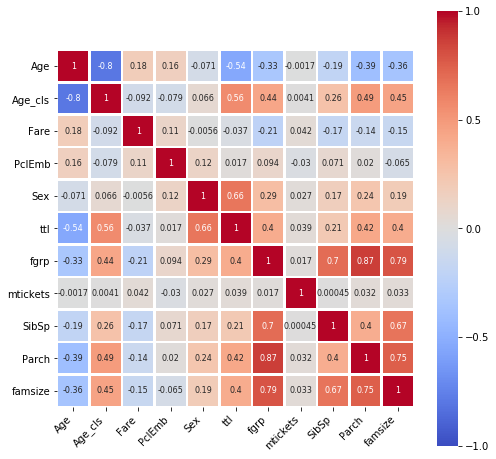

In [55]:
data = data[['Age', 'Age_cls', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets', 'SibSp', 'Parch', 'famsize']]
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

In [56]:
def add_counts(data, columns):
    n = len(data.index)
    for col in columns:
#         data['{0}_n'.format(col)] = data[col].apply(lambda i: len(data.loc[data[col]==i].index) / n)
        data[col] = data[col].apply(lambda i: np.log(i+1)) + data[col].apply(lambda i: len(data.loc[data[col]==i].index) / n)
    return data

In [57]:
# def combine_features(data, feature1, feature2, name):
#     lst1 = list(data[feature1].unique())
#     lst2 = list(data[feature2].unique())
#     d1 = len(lst1)
#     d2 = len(lst2)
#     mask = np.array(range(d1 * d2)).reshape(d1,d2)
#     data = data.copy()
#     df = []
#     for i in data.index:
#         df.append([mask[lst1.index(data[feature1][i])][lst2.index(data[feature2][i])]])
#     df = pd.DataFrame(df, columns=[name])
#     return pd.concat([data.reset_index(), df], axis=1).drop(columns='index')

In [58]:
# data = combine_features(data, 'Pclass', 'Embarked', 'PclEmb')
# data = combine_features(data, 'famsize', 'fgrp', 'fgrp_size')

In [59]:
# d1 = len(data['Pclass'].unique())
# d2 = len(data['Embarked'].unique())
# mask = np.array(range(d1 * d2)).reshape(d1,d2)
# data = data.copy()
# # data1['PclEmb'] = 0
# df = []
# for i in data1.index:
# #     print(data1['Pclass'][i])
#     df.append([mask[data['Pclass'][i]][data['Embarked'][i]]])
# df = pd.DataFrame(df, columns=['PclEmb'])
# data = pd.concat([data.reset_index(), df], axis=1).drop(columns='index')

In [60]:
# lst1 = list(data['famsize'].unique())
# lst2 = list(data['fgrp'].unique())
# d1 = len(lst1)
# d2 = len(lst2)
# mask = np.array(range(d1 * d2)).reshape(d1,d2)
# data = data.copy()
# # data1['PclEmb'] = 0
# df = []
# for i in data1.index:
# #     print(data1['Pclass'][i])
#     df.append([mask[lst1.index(data['famsize'][i])][lst2.index(data['fgrp'][i])]])
# df = pd.DataFrame(df, columns=['fgrp_size'])
# data = pd.concat([data.reset_index(), df], axis=1).drop(columns='index')

In [61]:
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

In [62]:
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

In [63]:
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

In [64]:
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

In [65]:
def dropcol_imp_r2_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.r2_score(y_valid, y_pred, sample_weight=sample_weights)

In [66]:
def dropcol_imp_roc_auc_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.roc_auc_score(y_valid, y_pred, sample_weight=sample_weights)

In [67]:
def dropcol_imp_accuracy_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.accuracy_score(y_valid, y_pred, sample_weight=sample_weights)

In [68]:
    def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
        """Plots confusion matrix
        Parameters:
        ax =  matplotlib axes
        normalyze = normalization over truth (number_predicted / total_count_of_this_class)
        """
        model.fit(X,y)
        conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                                  labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
        classes = y.unique()
        classes.sort()
        n_classes = [len(y[y == c]) for c in classes]
        if normalize == True:
            n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
            norm_matrix = conf_matrix / np.array(n_classes)
            ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
            labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                                   ns_matrix[i, j]) for j, v in
                                enumerate(norm_matrix[i])]
                               for i, v in enumerate(norm_matrix)])

            sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
        else:
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        
        ax.set_ylabel('True Labels')
        ax.set_xlabel('Predicted Labels')
        if title is None:
            title = model.__class__.__name__
        ax.set_title(title)
        ttl = ax.title
        ttl.set_position([.5, 1.07])

        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = ax.get_ylim()  # discover the values for bottom and top
        b += 0.5  # Add 0.5 to the bottom
        t -= 0.5  # Subtract 0.5 from the top
        ax.set_ylim(b, t)  # update the ylim(bottom, top) values

In [69]:
def feature_importance(model, X_train, y_train, X_test, y_test, metric, label=None):
    feature_importance = dropcol_importances(model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=metric)
    if label is None:
        label = model.__class__.__name__
    feature_importance.columns = [label]
    return feature_importance

In [70]:
def roc_auc_score_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovr', labels=None)

def roc_auc_score_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovo', labels=None)

In [71]:
data.columns

Index(['Age', 'Age_cls', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets',
       'SibSp', 'Parch', 'famsize'],
      dtype='object')

In [72]:
# train test split
X = data.drop(columns=['Age', 'Age_cls', 'Sex', 'mtickets', 'SibSp', 'Parch'])
y = data['Age_cls']

In [73]:
X.columns

Index(['Fare', 'PclEmb', 'ttl', 'fgrp', 'famsize'], dtype='object')

In [74]:
X['famsize'].unique()

array([ 1,  0,  4,  2,  6,  5,  3,  7, 10], dtype=int64)

In [75]:
# #common random_state
# random_state=30
# #cross validation strategy
# cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
# # cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
# #cross validation metrics
# scoring = {'balanced_accuracy': 'balanced_accuracy',
#            'roc_auc_ovr':  metrics.make_scorer(roc_auc_score_ovr, needs_proba=True),
#            'roc_auc_ovo':  metrics.make_scorer(roc_auc_score_ovo, needs_proba=True),
#            'precision_macro': 'precision_macro'}
# refit = 'roc_auc_ovr'

In [76]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)

#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [443]:
# n = len(y)
# class_priors = {}
# class_weights = {}
# for i in y.unique():
#     class_priors[i] = len(y.loc[y==i]) / n
#     class_weights[i] = 1- class_priors[i]

In [444]:
# class_weights

In [77]:
age_cls_model = gaup.GaussianProcessClassifier(kernel=None, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, random_state=random_state)
# param_ranges = {'base_estimator__max_iter_predict': np.arange(1, 50, 10)}
# gpc, scores = train_best_model_cal(gpc, param_ranges, X, y, scoring, cv, refit=refit)
param_ranges = {'max_iter_predict': np.arange(1, 15)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.952920  0.993895         0.923336
std_train            0.018968  0.001816         0.013450
mean_test            0.923869  0.989862         0.913722
std_test             0.036268  0.005878         0.035575
{'max_iter_predict': 3}


In [78]:
#             balanced_accuracy   roc_auc  precision_macro
# mean_train           0.965773  0.994313         0.928895
# std_train            0.017776  0.001452         0.017162
# mean_test            0.941522  0.985114         0.924102
# std_test             0.036443  0.007693         0.041806
# {'max_iter_predict': 4}

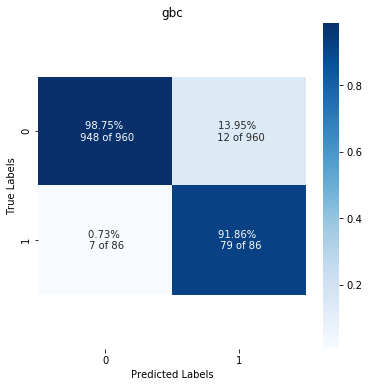

In [79]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(age_cls_model, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='gbc')

In [80]:
# dtc = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
#                                  min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                                  max_features=None, random_state=random_state, 
#                                  max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                                  class_weight='balanced', 
#                                  ccp_alpha=0.0)
# # etc = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
# param_ranges = {'max_depth': np.arange(3, 10)}
# dtc, scores = train_best_model(dtc, param_ranges, X, y, scoring, cv, refit=refit)
# # base_scores['etc'] = scores.loc['mean_test', refit]

In [81]:
# fig = plt.figure()
# fig.set_size_inches(6,6)
# plot_confusion_matrix(dtc, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='gbc')

In [82]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               min_samples_split=2,
                               min_samples_leaf=1)
# etc = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['etc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.974513  0.993905         0.933975
std_train            0.013818  0.001701         0.018359
mean_test            0.933003  0.990388         0.924510
std_test             0.032596  0.004890         0.050529
{'max_depth': 9, 'n_estimators': 45}


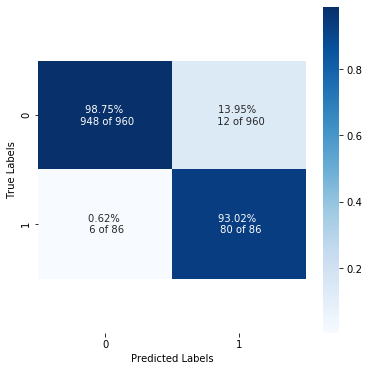

In [83]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(etc, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

Optimal number of features : 2
Features to drop: 

['Fare', 'PclEmb', 'famsize']


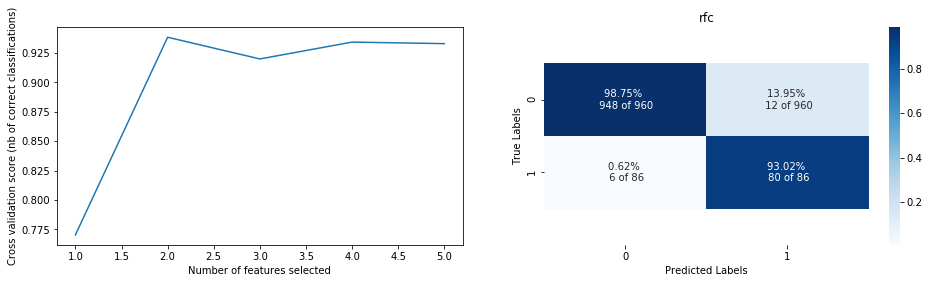

In [84]:
rfecv = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(etc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [469]:
# train test split
X = data.drop(columns=['Age', 'Sex', 'mtickets', 'SibSp', 'Parch'])
y = data['Age']

In [470]:
X.columns

Index(['Age_cls', 'Fare', 'PclEmb', 'ttl', 'fgrp', 'famsize'], dtype='object')

In [471]:
#Train/Test split
# X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, random_state=30)
#common random_state
random_state=30
#cross validation strategy
cv_folds = 5
# n_repeats = 10
cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
# cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
#cross validation metrics
scoring = {'explained_variance':  'explained_variance',
           'r2': 'r2'}
refit='r2'

In [472]:
age_reg_mogel = ens.RandomForestRegressor(min_samples_split = 2, min_samples_leaf = 1, random_state=random_state, n_jobs=-1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.745876  0.745871
std_train             0.021362  0.021361
mean_test             0.699036  0.697558
std_test              0.037380  0.037457
{'max_depth': 4, 'n_estimators': 85}


In [514]:
#             explained_variance        r2
# mean_train            0.747108  0.747102
# std_train             0.020571  0.020572
# mean_test             0.697343  0.695833
# std_test              0.036359  0.036432
# {'max_depth': 4, 'n_estimators': 85}

### Preprocess train set for classification

**Pipeline:**
1. Encode name
2. Encode title
3. Encode embarked
4. Encode familie groups
5. Encode fare
6. Encode sex
7. Add familie size
8. Encode age

In [515]:
# def fare_transformer(data):
#     c = data['Fare'].apply(lambda i: np.log(i+1)).to_frame()
#     kbd = prepc.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
#     c = pd.DataFrame(kbd.fit_transform(np.array(c).reshape(-1,1)), columns=['Fare'])
#     c = c.astype(int)
#     return pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [516]:
# def fare_transformer(data):
#     c = data['Fare'].apply(lambda i: np.log(i+1)).to_frame()
#     data = data.drop(columns='Fare')
#     data = pd.concat([data, c], axis=1)
#     kbd = prepc.KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans')
#     c = pd.DataFrame(kbd.fit_transform(np.array(data['Fare']).reshape(-1,1)), columns=['Fare'])
#     c = c.astype(int)
#     return pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [517]:
#Age encoder
# def age_encoder(data, final_model_age):
#     data = fare_transformer(data)
#     data_na = data[data['Age'].isnull()]
#     data_notna = data[data['Age'].notna()]
#     #transform non-null age values
#     data_notna = age_transformer(data_notna)
#     #predict missing values
#     y = pd.Series(final_model_age.predict(data_na[['Fare', 'Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked']]), name='Age').to_frame()
#     data_na = pd.concat([data_na.reset_index().drop(columns=['Age', 'index']), y], axis=1)
#     data = pd.concat([data_na, data_notna])
#     kbd = prepc.KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')
#     c = pd.DataFrame(kbd.fit_transform(np.array(data['Age']).reshape(-1,1)), columns=['Age'])
#     c = c.astype(int)
#     return pd.concat([data.drop(columns=['Age']).reset_index(), c], axis=1).drop(columns='index')

In [475]:
#Age encoder
def age_predictor(data, age_cls_model, age_reg_mogel):
#     data = fare_transformer(data)
#     cols = ['Fare', 'Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked']
    cols = ['Fare', 'PclEmb', 'ttl', 'fgrp', 'famsize']
    data_na = data[data['Age'].isnull()]
    data_notna = data[data['Age'].notna()]

    # transform non-null age values
    age_trans = data_notna['Age'].apply(lambda i: np.log(i+1)).to_frame()
    data_notna = pd.concat([data_notna.drop(columns=['Age']), age_trans], axis=1)

    # predict class labels
    X = data_na[cols].reset_index().drop(columns='index')
    age_cls = pd.Series(age_cls_model.predict(X), name='Age_cls').to_frame()
    X_age_cls = pd.concat([X, age_cls], axis=1)

    # predict age
    age_preds = pd.Series(age_reg_mogel.predict(X_age_cls), name='Age').to_frame()
    data_na = pd.concat([data_na.reset_index().drop(columns=['Age', 'index']), age_preds], axis=1)
    return pd.concat([data_na, data_notna])
#     data = pd.concat([data_na, data_notna])
    
#     kbd = prepc.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
#     c = pd.DataFrame(kbd.fit_transform(np.array(data['Age']).reshape(-1,1)), columns=['Age_cls'])
#     c = c.astype(int)
#     return pd.concat([data.reset_index(), c], axis=1).drop(columns='index')

In [536]:
data_train1 = name_encoder(data_train)
data_train1 = title_encoder(data_train1)
data_train1 = embarked_encoder(data_train1)
data_train1 = pclass_encoder(data_train1)
data_train1 = family_groups_encoder(data_train1, fam_grps)
data_train1 = family_encoder(data_train1, [sig1, fam1, famch1])
data_train1 = fare_encoder(data_train1, [sig1, fam1, famch1])
data_train1 = sex_encoder(data_train1)
data_train1 = combine_features(data_train1, 'Pclass', 'Embarked', 'PclEmb')
# data_train1 = fam_size(data_train1)
data_train1 = age_predictor(data_train1, age_cls_model, age_reg_mogel)

In [538]:
#Predict class labels
age_cls = pd.DataFrame(age_clast_model.fit_predict(np.array(data_train1['Age']).reshape(-1,1)), columns=['Age_cls'])
age_cls = age_cls.astype(int)
# age_cls
data_train1 = pd.concat([data_train1.reset_index(), age_cls], axis=1).drop(columns='index')

In [539]:
data_train1

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl,fgrp,mtickets,famsize,Sex,PclEmb,Age,Age_cls
0,6,0,2,"Moran, Mr. James",0,0,330877,8.458300e+00,NaN,2,Moran,,1,0,1,0,0,2,1.765019,1
1,18,1,1,"Williams, Mr. Charles Eugene",0,0,244373,1.300000e+01,NaN,1,Williams,,1,0,1,0,0,6,1.765019,1
2,20,1,2,"Masselmani, Mrs. Fatima",0,0,2649,7.225000e+00,NaN,0,Masselmani,,2,0,1,0,1,1,1.637787,1
3,27,0,2,"Emir, Mr. Farred Chehab",0,0,2631,7.225000e+00,NaN,0,Emir,,1,0,1,0,0,1,1.627768,1
4,29,1,2,"O'Dwyer, Miss. Ellen ""Nellie""",0,0,330959,7.879200e+00,NaN,2,O'Dwyer,,3,0,0,0,1,2,1.767698,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,"Rice, Mrs. William (Margaret Norton)",0,1,382652,2.028901e-23,NaN,2,Rice,Norton,2,5,0,5,1,2,3.688879,0
887,887,0,1,"Montvila, Rev. Juozas",0,0,211536,1.300000e+01,NaN,1,Montvila,,1,0,0,0,0,6,3.332205,0
888,888,1,0,"Graham, Miss. Margaret Edith",0,0,112053,3.000000e+01,B42,1,Graham,,3,0,1,0,1,3,2.995732,0
889,890,1,0,"Behr, Mr. Karl Howell",0,0,111369,3.000000e+01,C148,0,Behr,,1,0,0,0,0,4,3.295837,0


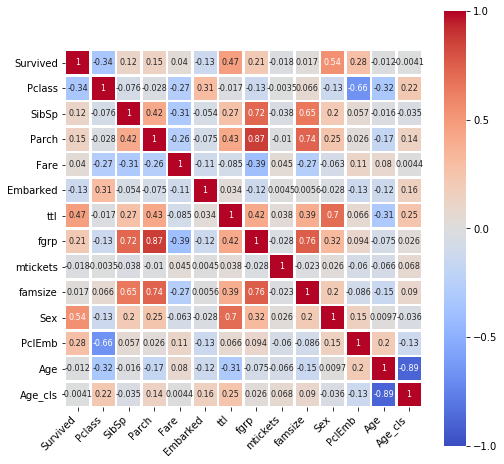

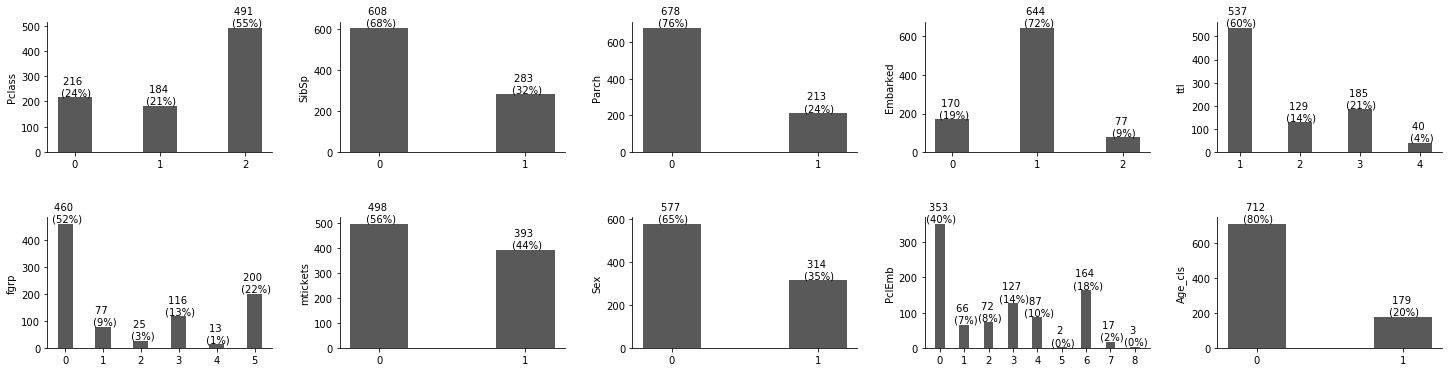

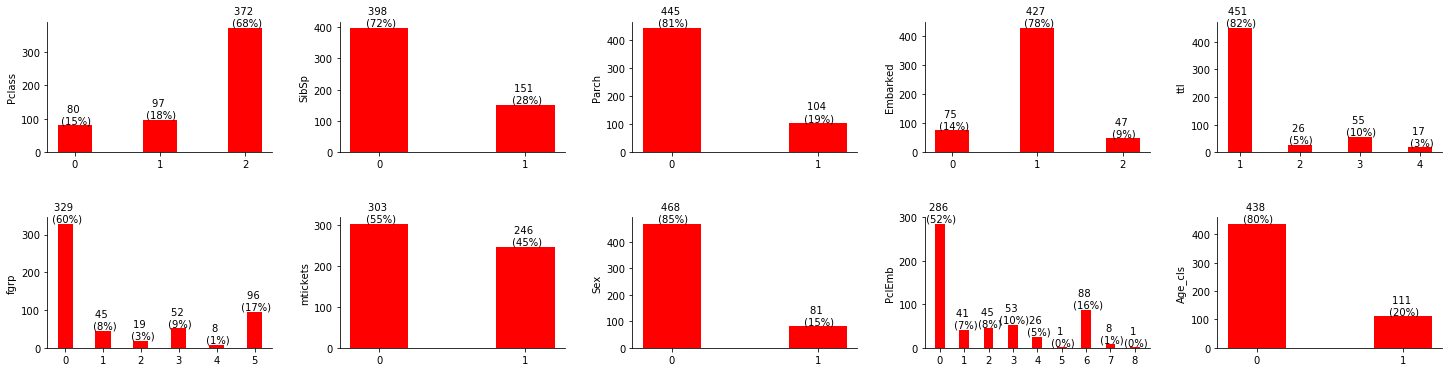

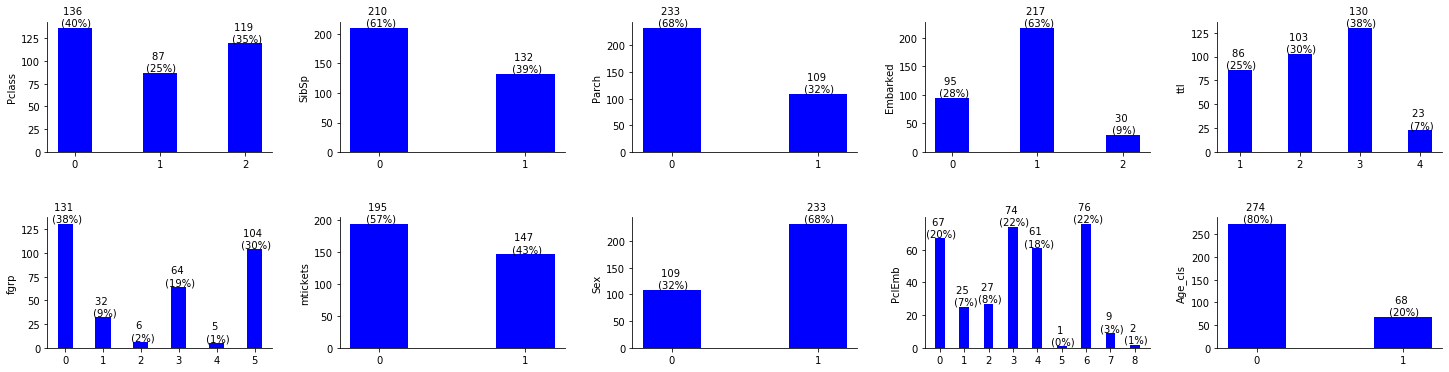

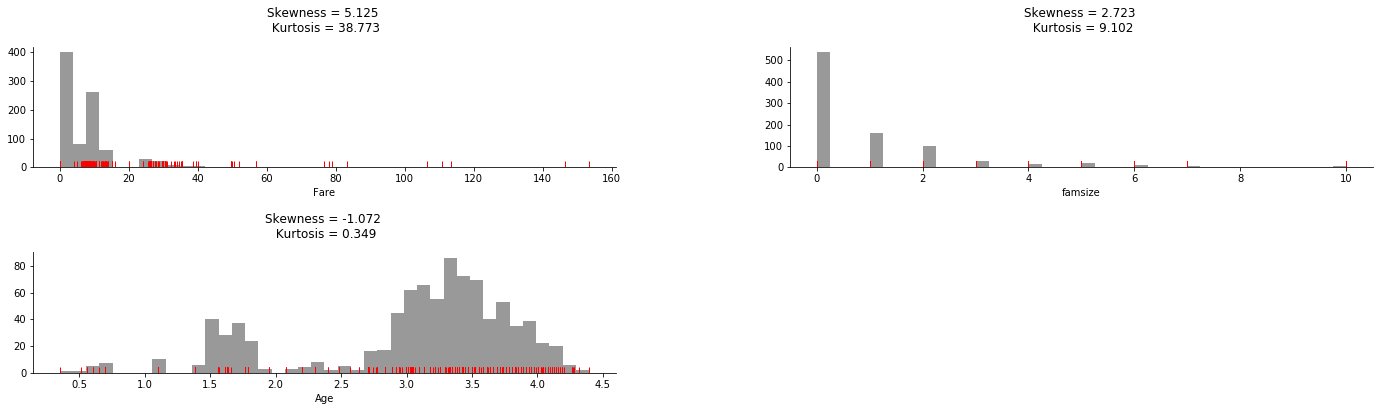

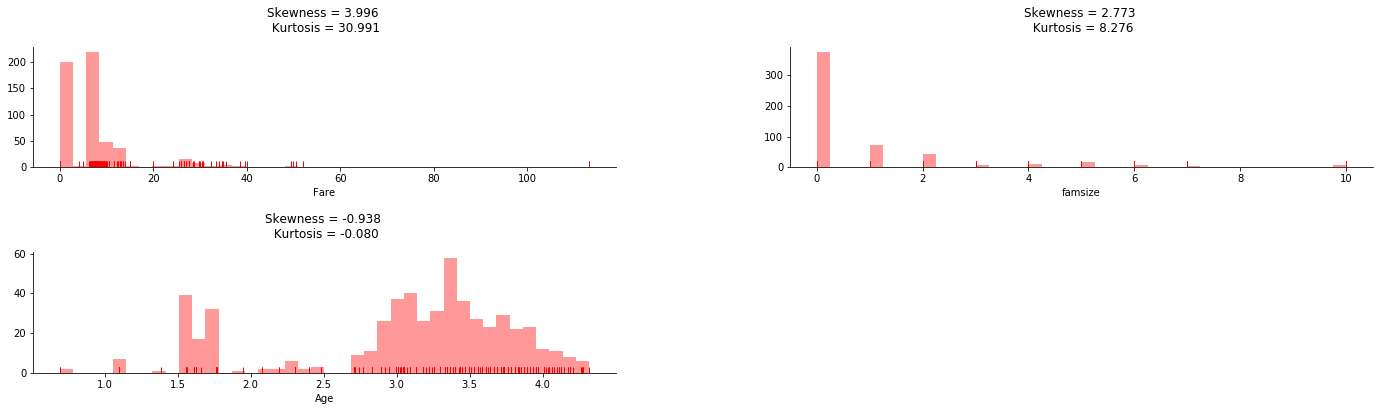

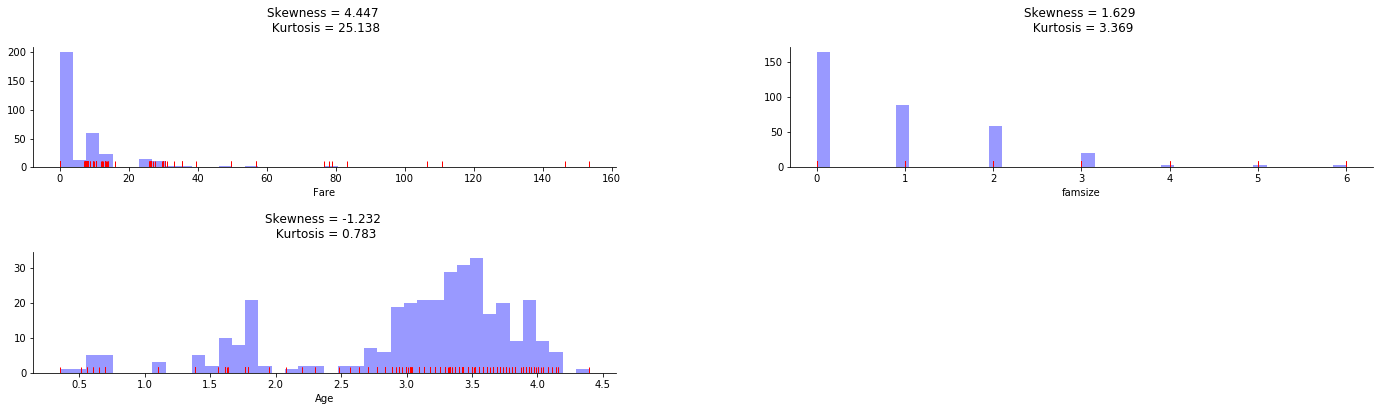

In [541]:
data = data_train1[['Survived','Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'ttl', 'fgrp', 'mtickets', 'famsize', 'Sex', 'PclEmb', 'Age', 'Age_cls']]
data_cat = data[['Pclass', 'SibSp', 'Parch', 'Embarked', 'ttl','fgrp', 'mtickets','Sex', 'PclEmb', 'Age_cls']]
data_num = data[['Fare', 'famsize', 'Age']]

#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


In [482]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [483]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
#         print(model.predict_proba(X))
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
#         print(proba_0)
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

In [704]:
# train test split
# X = data.drop(columns=['Survived', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Age_cls', 'Sex', 'mtickets'])
X = data.drop(columns=['Survived', 'Pclass', 'Embarked', 'fgrp', 'Age_cls', 'Sex', 'SibSp', 'Parch', 'mtickets'])
y = data['Survived']

In [705]:
# def add_counts(data, columns):
#     n = len(data.index)
#     for col in columns:
# #         data['{0}_n'.format(col)] = data[col].apply(lambda i: len(data.loc[data[col]==i].index) / n)
#         data[col] = data[col].apply(lambda i: np.log(i+1)) + data[col].apply(lambda i: len(data.loc[data[col]==i].index) / n)
#     return data

In [706]:
# X = add_counts(X, ['Pclass', 'ttl', 'Embarked', 'Sex', 'Fare', 'Age', 'famsize', 'fgrp'])

In [707]:
X.columns

Index(['Fare', 'ttl', 'famsize', 'PclEmb', 'Age'], dtype='object')

In [708]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [709]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [679]:
bm = [('gpc', gaup.GaussianProcessClassifier()),
      ('lda', disan.LinearDiscriminantAnalysis()),
      ('qda', disan.QuadraticDiscriminantAnalysis()),
      ('abc', ens.AdaBoostClassifier()),
      ('gbc', ens.GradientBoostingClassifier()),
      ('etc', ens.ExtraTreesClassifier()),
      ('rfc', ens.RandomForestClassifier()),
      ('lr', lm.LogisticRegression()),
      ('pac', lm.PassiveAggressiveClassifier()),
      ('rc', lm.RidgeClassifier()),
      ('svc', svm.SVC()),
      ('lsvc', svm.LinearSVC()),
      ('nusvc', svm.NuSVC())]

In [697]:
bm = [('gpc', gaup.GaussianProcessClassifier()),
      ('qda', disan.QuadraticDiscriminantAnalysis()),
      ('abc', ens.AdaBoostClassifier()),
      ('gbc', ens.GradientBoostingClassifier()),
      ('etc', ens.ExtraTreesClassifier()),
      ('pac', lm.PassiveAggressiveClassifier()),
      ('rc', lm.RidgeClassifier()),
      ('nusvc', svm.NuSVC())]

In [698]:
for m in bm:
    lbl, mdl = m
    mdl.fit(X,y)

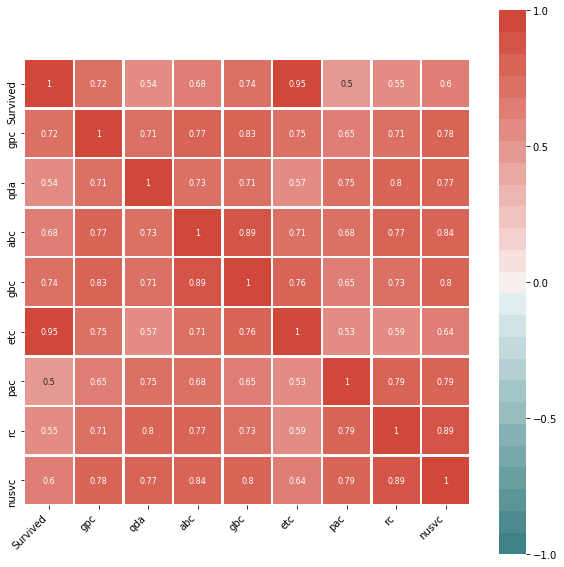

In [699]:
preds_base = base_models_predictions(bm, X)
preds_base = pd.concat([y.reset_index().drop(columns=['index']), preds_base], axis=1)
# data = pd.concat([pd.DataFrame(final_model_surv_st.predict_proba(X_test), columns=['final_pred_0', 'final_pred_1']), data], axis=1)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [700]:
model_st = ens.StackingClassifier(estimators=bm,
                                          final_estimator=ens.RandomForestClassifier(),
                                          cv=5, 
                                          stack_method='predict', 
                                          n_jobs=-1)
cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.849207,0.918270,0.865686
std_train,0.031095,0.027942,0.035646
mean_test,0.791818,0.825708,0.808765
std_test,0.024101,0.029968,0.025078


In [701]:
param_ranges = {'final_estimator__n_estimators': np.arange(5, 100, 20),
                'final_estimator__max_depth': np.arange(5, 10)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.867922  0.930970         0.888543
std_train            0.015917  0.025859         0.018123
mean_test            0.799700  0.843695         0.819359
std_test             0.025445  0.029606         0.021847
{'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 45}


In [710]:
base_scores = {}

In [715]:
gpc = gaup.GaussianProcessClassifier(kernel=None, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, random_state=random_state)
param_ranges = {'max_iter_predict': np.arange(1, 50, 10)}
gpc, scores = train_best_model(gpc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['gpc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.868110  0.906499         0.887061
std_train            0.010226  0.008561         0.006359
mean_test            0.772404  0.853516         0.793653
std_test             0.027428  0.024087         0.028624
{'max_iter_predict': 11}


In [669]:
lda = disan.LinearDiscriminantAnalysis(solver='svd', shrinkage=None)
param_ranges = {'n_components': np.arange(1,10)}
lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lda'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.765381  0.826720         0.791741
std_train            0.013298  0.011452         0.013620
mean_test            0.752554  0.817523         0.784640
std_test             0.021794  0.018754         0.018351
{'base_estimator__n_components': 1}


In [716]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]])
param_ranges = {'reg_param': np.linspace(0.01,1,12)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['qda'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.764240  0.824493         0.785638
std_train            0.009318  0.009956         0.011519
mean_test            0.752318  0.823519         0.777745
std_test             0.025323  0.018812         0.023482
{'reg_param': 0.01}


In [717]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', random_state=random_state)
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.3, 20)}
abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['abc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821043  0.885475         0.833646
std_train            0.011880  0.010607         0.012153
mean_test            0.805284  0.861180         0.821341
std_test             0.021401  0.017723         0.020648
{'learning_rate': 0.04821052631578947, 'n_estimators': 65}


Optimal number of features : 5
Features to drop: 

[]


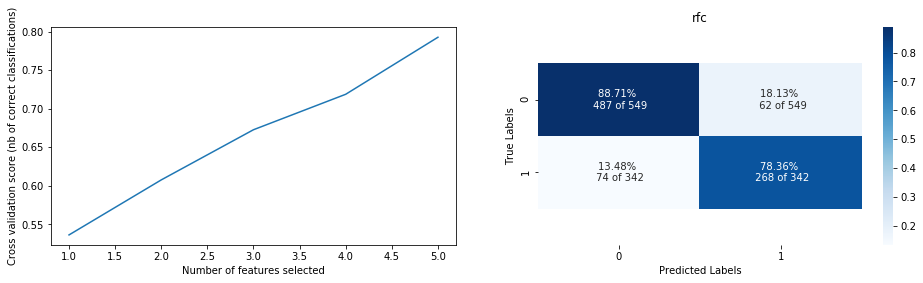

In [678]:
rfecv = feature_selection.RFECV(estimator=abc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(abc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [718]:
gbc = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                     min_samples_split=2, min_samples_leaf=1,
                                     init=None, random_state=random_state, 
                                     max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 10), 'n_estimators': np.arange(5, 100, 20)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'min_impurity_decrease': np.linspace(0.01, 0.2, 15)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'subsample': np.linspace(0.1, 1.1, 15), 'max_depth': np.arange(3, 6)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)


base_scores['gbc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.871896  0.934033         0.856205
std_train            0.012852  0.009904         0.008160
mean_test            0.810380  0.862068         0.856867
std_test             0.025135  0.019978         0.010431
{'learning_rate': 0.07333333333333333, 'n_estimators': 85}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.864194  0.901119         0.842618
std_train            0.012002  0.012117         0.012103
mean_test            0.809467  0.869729         0.836784
std_test             0.026186  0.023950         0.019155
{'min_impurity_decrease': 0.01, 'min_weight_fraction_leaf': 0.01}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.865282  0.946691         0.879403
std_train            0.011560  0.007726         0.009315
mean_test            0.811224  0.865660         0.832227
std_test             0.022107  0.024237         0.022918
{'max_depth': 3, 'su

Optimal number of features : 5
Features to drop: 

[]


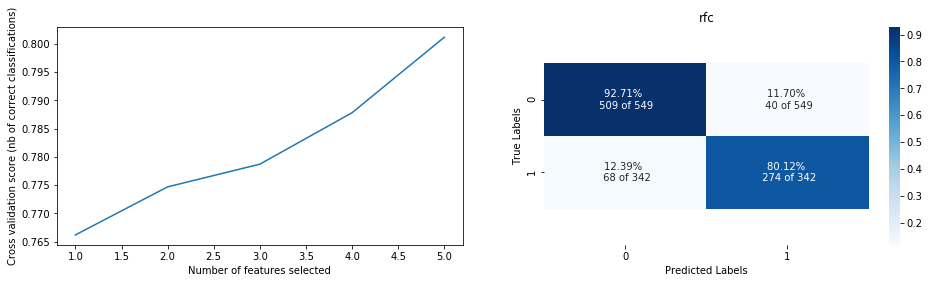

In [672]:
rfecv = feature_selection.RFECV(estimator=gbc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(gbc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [729]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['etc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.825567  0.912412         0.851246
std_train            0.011243  0.007910         0.008866
mean_test            0.800306  0.871180         0.836658
std_test             0.024221  0.020256         0.024948
{'max_depth': 4, 'n_estimators': 45}


Optimal number of features : 5
Features to drop: 

[]


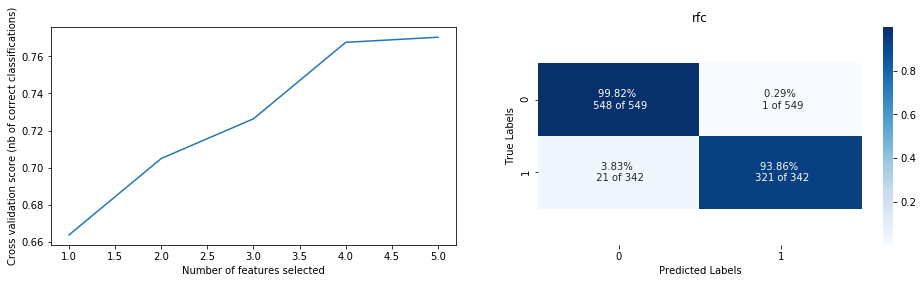

In [674]:
rfecv = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(etc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [675]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'base_estimator__n_estimators': np.arange(5, 100, 20),
                'base_estimator__max_depth': np.arange(5, 10)}
rfc, scores = train_best_model_cal(rfc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['rfc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.850956  0.934128         0.872041
std_train            0.016121  0.008932         0.013339
mean_test            0.808064  0.869974         0.832312
std_test             0.023351  0.019164         0.021726
{'base_estimator__max_depth': 5, 'base_estimator__n_estimators': 45}


Optimal number of features : 5
Features to drop: 

[]


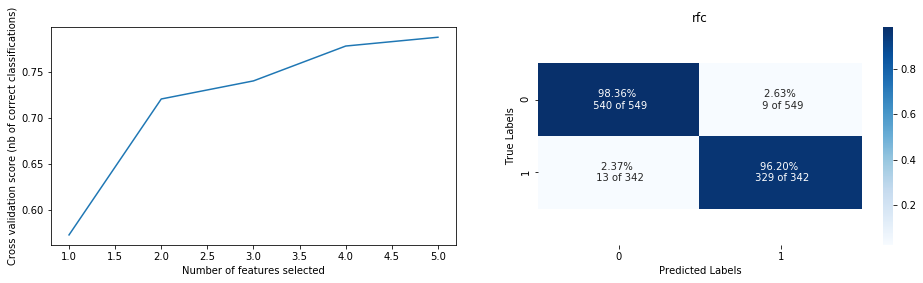

In [676]:
rfecv = feature_selection.RFECV(estimator=rfc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(rfc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [702]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1)
param_ranges = {'base_estimator__C': np.linspace(0.01, 5, 20)}
lr, scores = train_best_model_cal(lr, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lr'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.760467  0.827402         0.789249
std_train            0.013389  0.011705         0.014627
mean_test            0.749214  0.817152         0.784059
std_test             0.021673  0.019465         0.018404
{'base_estimator__C': 0.7978947368421053}


In [720]:
pac = lm.PassiveAggressiveClassifier(class_weight=class_weights, random_state=random_state, n_jobs=-1)
param_ranges = {'C': np.linspace(0.01, 1, 20)}
pac, scores = train_best_model(pac, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['pac'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.728593  0.779612         0.740199
std_train            0.036011  0.029935         0.029870
mean_test            0.716387  0.771486         0.730049
std_test             0.049102  0.030243         0.047461
{'C': 0.01}


In [721]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state, solver='auto')
param_ranges = {'alpha': np.linspace(0.01, 40, 20)}
rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['rc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.766177  0.826913         0.769046
std_train            0.022871  0.011272         0.025910
mean_test            0.749138  0.817052         0.756537
std_test             0.026479  0.019108         0.033194
{'alpha': 0.01}


In [562]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights)
param_ranges = {'base_estimator__C': np.linspace(0.01, 10, 20)}
svc, scores = train_best_model_cal(svc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['svc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.823849  0.864461         0.820977
std_train            0.012711  0.011614         0.012158
mean_test            0.794572  0.849835         0.796602
std_test             0.030643  0.028661         0.028216
{'base_estimator__C': 10.0}


In [563]:
lsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', class_weight=class_weights, max_iter=1500, tol=0.05)
param_ranges = {'base_estimator__C': np.linspace(0.005, 1, 20)}
lsvc, scores = train_best_model_cal(lsvc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lsvc'] = scores.loc['mean_test', refit]

c:\00_data\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\00_data\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\00_data\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


            balanced_accuracy   roc_auc  precision_macro
mean_train           0.811810  0.870165         0.825688
std_train            0.011367  0.014196         0.010861
mean_test            0.794790  0.861698         0.812037
std_test             0.021949  0.025680         0.020513
{'base_estimator__C': 0.057368421052631575}


In [722]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights)
param_ranges = {'nu': np.linspace(0.1,1,10)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['nusvc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.824255  0.878008         0.844747
std_train            0.023212  0.010005         0.008549
mean_test            0.778167  0.834557         0.801799
std_test             0.019165  0.024373         0.033073
{'nu': 0.30000000000000004}


In [732]:
pd.Series(base_scores, name='test').sort_values(ascending=False)

gbc      0.811224
abc      0.805284
etc      0.800306
nusvc    0.778167
gpc      0.772404
rc       0.749138
pac      0.716387
Name: test, dtype: float64

In [697]:
bm = [('gpc', gaup.GaussianProcessClassifier()),
      ('qda', disan.QuadraticDiscriminantAnalysis()),
      ('abc', ens.AdaBoostClassifier()),
      ('gbc', ens.GradientBoostingClassifier()),
      ('etc', ens.ExtraTreesClassifier()),
      ('pac', lm.PassiveAggressiveClassifier()),
      ('rc', lm.RidgeClassifier()),
      ('nusvc', svm.NuSVC())]

In [566]:
# base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [723]:
base_models_surv_dic = {'qda':qda,'abc':abc,'etc':etc,'pac':pac,'rc':rc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [724]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

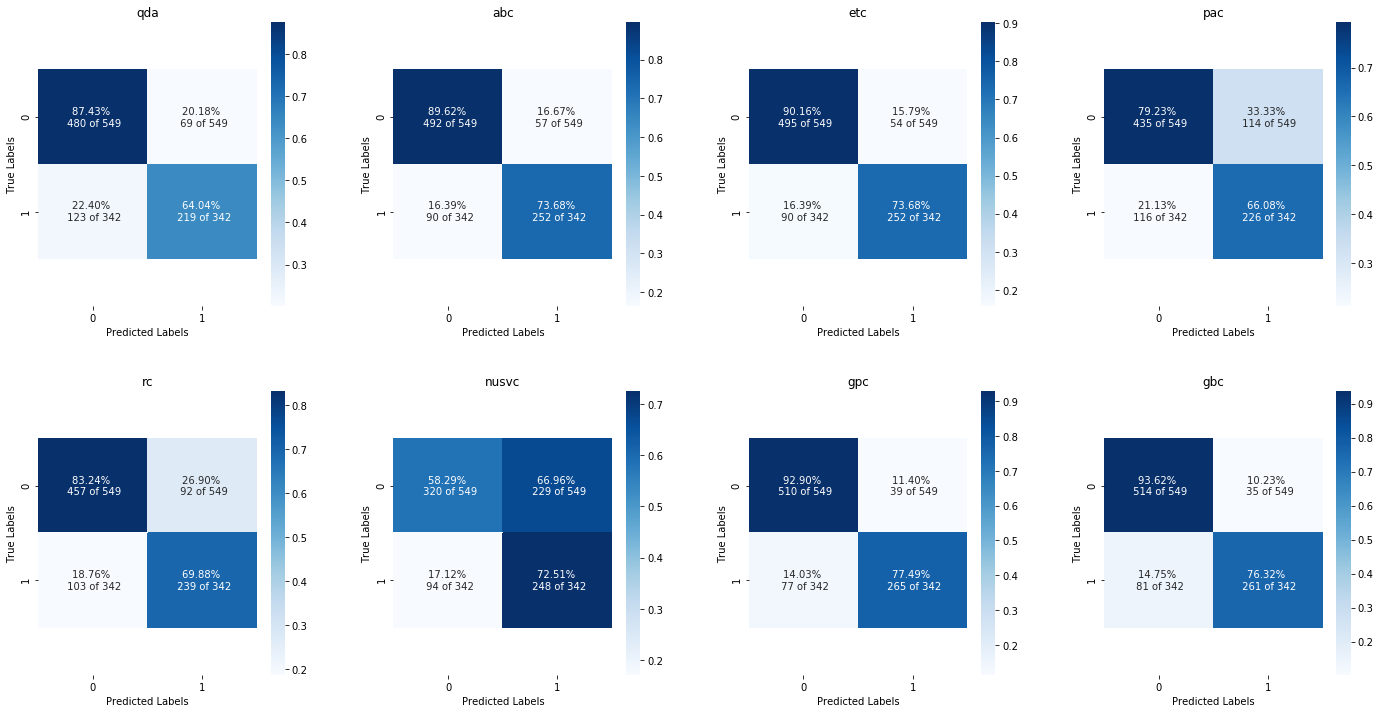

In [725]:
grd_n = len(base_models_surv)
grd_cols_n = 4
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

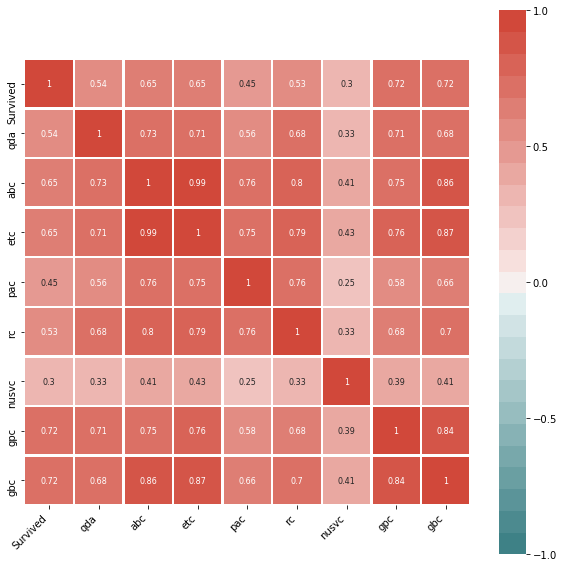

In [726]:
preds_base = base_models_predictions(base_models_surv, X)
preds_base = pd.concat([y.reset_index().drop(columns=['index']), preds_base], axis=1)
# data = pd.concat([pd.DataFrame(final_model_surv_st.predict_proba(X_test), columns=['final_pred_0', 'final_pred_1']), data], axis=1)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [727]:
corr_matrix.drop(index='Survived')

,Survived,qda,abc,etc,pac,rc,nusvc,gpc,gbc
qda,0.535145,1.000000,0.726624,0.712990,0.558694,0.680405,0.326294,0.712322,0.684336
abc,0.646806,0.726624,1.000000,0.987613,0.757687,0.801356,0.414058,0.748905,0.862851
etc,0.653896,0.712990,0.987613,1.000000,0.745546,0.789093,0.427365,0.760722,0.869845
pac,0.453674,0.558694,0.757687,0.745546,1.000000,0.758771,0.250054,0.584752,0.657536
rc,0.534678,0.680405,0.801356,0.789093,0.758771,1.000000,0.329709,0.676396,0.700439
nusvc,0.300348,0.326294,0.414058,0.427365,0.250054,0.329709,1.000000,0.385655,0.408658
gpc,0.721942,0.712322,0.748905,0.760722,0.584752,0.676396,0.385655,1.000000,0.844398
gbc,0.722144,0.684336,0.862851,0.869845,0.657536,0.700439,0.408658,0.844398,1.000000


In [728]:
cm = corr_matrix.drop(index='Survived')
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (cm[k].sum() - 1) / len(cm.index)
    
df_base_models_corr_sc = pd.concat([cm['Survived'], pd.Series(corr_sc)], axis=1)
df_base_models_corr_sc.sort_values(by=0, ascending=False)

,Survived,0
abc,0.646806,0.662387
etc,0.653896,0.661647
gbc,0.722144,0.628508
rc,0.534678,0.592021
gpc,0.721942,0.589144
qda,0.535145,0.550208
pac,0.453674,0.539130
nusvc,0.300348,0.317724


In [263]:
#opt
# base_models_surv_dic = {'rfc':rfc,'lr':lr,'pac':pac,'svc':svc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc,'qda':qda}

In [572]:
base_models_surv_dic = {'lda':lda,'qda':qda,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'svc':svc,'gpc':gpc,'gbc':gbc}

In [730]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                                                                         min_samples_split=2, min_samples_leaf=1,
                                                                                         init=None, random_state=random_state, 
                                                                                         max_features=None, max_leaf_nodes=None, 
                                                                                         validation_fraction=0.1, n_iter_no_change=None, 
                                                                                         tol=0.0001, ccp_alpha=0.0),
                                  cv=5, 
                                  stack_method='predict', 
                                  n_jobs=-1)
cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.837783,0.868070,0.854224
std_train,0.013588,0.027998,0.010831
mean_test,0.800912,0.822109,0.822030
std_test,0.024608,0.027316,0.025522


In [731]:
param_ranges = {'final_estimator__learning_rate': np.linspace(0.01, 0.2, 10), 'final_estimator__n_estimators': np.arange(5, 100, 20)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'final_estimator__min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'final_estimator__min_impurity_decrease': np.linspace(0.01, 0.2, 15)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'final_estimator__subsample': np.linspace(0.1, 1.1, 15), 'final_estimator__max_depth': np.arange(3, 6)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.845184  0.878531         0.864946
std_train            0.019000  0.027996         0.014843
mean_test            0.803039  0.836837         0.838901
std_test             0.025870  0.018306         0.019405
{'final_estimator__learning_rate': 0.1366666666666667, 'final_estimator__n_estimators': 25}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.847379  0.889488         0.862006
std_train            0.021619  0.011360         0.018225
mean_test            0.811286  0.843504         0.830083
std_test             0.019533  0.019533         0.020790
{'final_estimator__min_impurity_decrease': 0.01, 'final_estimator__min_weight_fraction_leaf': 0.07333333333333333}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.848019  0.889749         0.864889
std_train            0.021756  0.013126         0.022432
mean_test            0.811954  0.844445         0.83

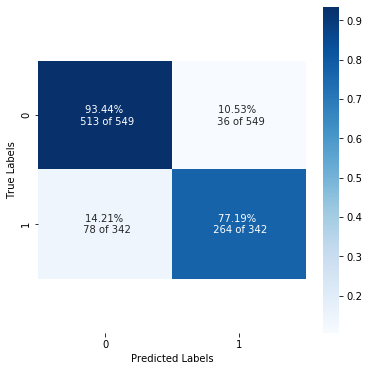

In [733]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [734]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, 
                                                                             criterion='gini',
                                                                             min_samples_split=2,
                                                                             min_samples_leaf=1),
                                  cv=5, 
                                  stack_method='predict', 
                                  n_jobs=-1)
cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.841646,0.860524,0.859483
std_train,0.016490,0.032773,0.015996
mean_test,0.797211,0.821356,0.818963
std_test,0.019452,0.017663,0.021562


In [735]:
param_ranges = {'final_estimator__n_estimators': np.arange(5, 100, 20),
                'final_estimator__max_depth': np.arange(5, 10)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.835552  0.881773         0.855582
std_train            0.013604  0.019950         0.013817
mean_test            0.801336  0.839120         0.822795
std_test             0.023435  0.024899         0.019172
{'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 85}


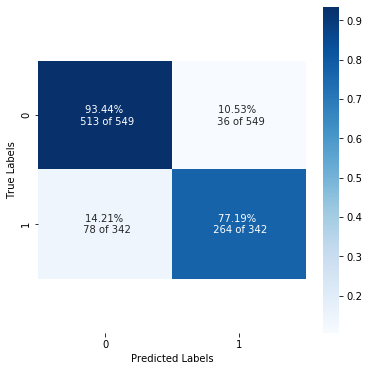

In [733]:
fig = plt.figure()
fig.set_size_inches(6,6)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [573]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

In [266]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = res.loc['mean_test', score]
    return pd.DataFrame(scores, index=['Test_score'])

In [268]:
train_final_models(base_models_surv, X, y, cv_folds=5, score=refit)

,lda,qda,abc,etc,rfc,lr,pac,rc,svc,lsvc,nusvc,gpc,gbc
Test_score,0.796113,0.638942,0.795127,0.778887,0.778593,0.787908,0.702181,0.791251,0.781535,0.791251,0.795727,0.790953,0.778593


In [647]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [648]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

In [649]:
train_final_models(base_models_surv, X, y, cv_folds=5, score='accuracy')

,rfc,lr,pac,svc,nusvc,gpc,gbc,qda
Test_score,0.794776,0.805504,0.740672,0.803638,0.803172,0.801772,0.798974,0.78125


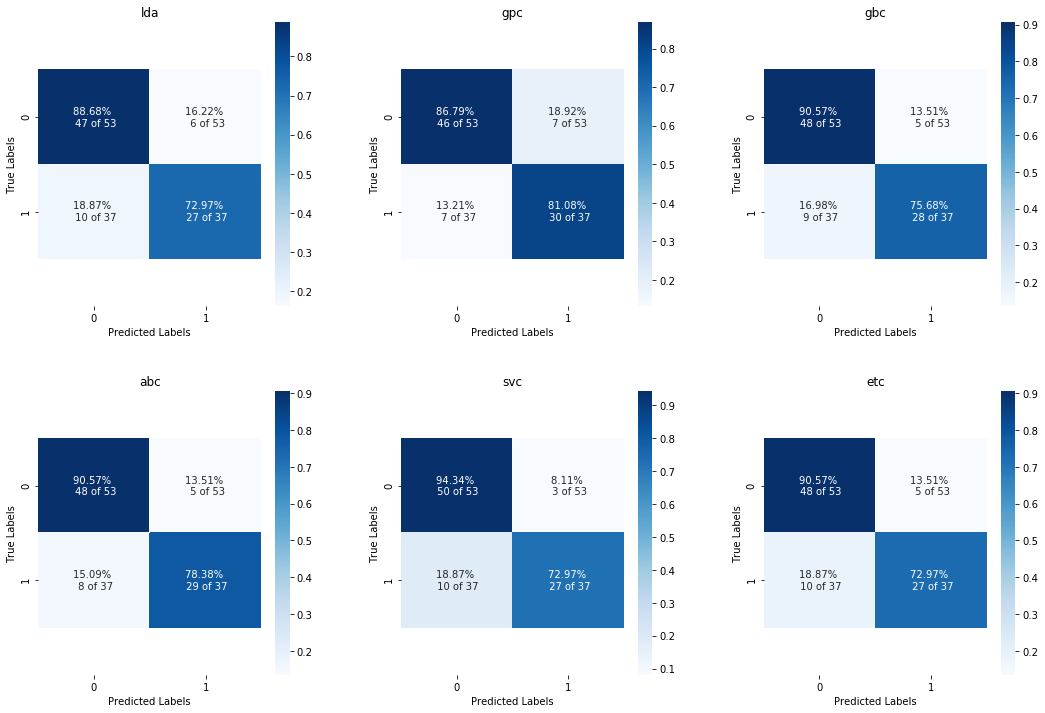

In [444]:
grd_n = len(fin_models_surv)
grd_cols_n = 3
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X_test, y_test, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [440]:
fin_models_surv_dic = {'lda':lda,'gpc':gpc,'gbc':gbc,'abc':abc,'svc':svc,'etc':etc}

In [441]:
fin_models_surv = [(k,fin_models_surv_dic[k]) for k in fin_models_surv_dic.keys()]

In [398]:
pred_test = final_model_surv_vt.predict_proba(X_test)
len(pred_test[:,1]>0.9)

90